# **Team Number ```31```**

**Team Name ``DeepAI``**

**Project Name ``Weather Forecasting``**

**Instructor :``Eraliev Oybek``**

**Teaching Assistant:``Jasurbek Mamurov``**

# **WeatherCast Model**
**Linear Regressional Model**

## **Libraries to Install** 

In [61]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import pytz
import requests
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit


## **Configuration & Helper Functions**



In [62]:
API_KEY = '0ea12166dca6efaa2a7077602c59e70d'
BASE_URL = 'https://api.openweathermap.org/data/2.5/'

def get_current_weather(lat=41.2995, lon=69.2401):
    """Fetch current weather from OpenWeatherMap API"""
    try:
        url = f"{BASE_URL}weather?lat={lat}&lon={lon}&appid={API_KEY}&units=metric"
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        data = response.json()

        temp = data['main']['temp']
        temp_min = data['main']['temp_min']
        temp_max = data['main']['temp_max']
        feels_like = data['main']['feels_like']
        
        if temp > 100:
            temp = temp - 273.15
        if temp_min > 100:
            temp_min = temp_min - 273.15
        if temp_max > 100:
            temp_max = temp_max - 273.15
        if feels_like > 100:
            feels_like = feels_like - 273.15
        
        return {
            'city': data.get('name', 'Tashkent'),
            'country': data['sys'].get('country', 'UZ'),
            'current_temp': round(temp, 2),
            'temp_min': round(temp_min, 2),
            'temp_max': round(temp_max, 2),
            'feels_like': round(feels_like, 2),
            'humidity': data['main']['humidity'],
            'pressure': data['main']['pressure'],
            'wind_speed': data['wind']['speed'],
            'wind_gust': data['wind'].get('gust', data['wind']['speed']),
            'wind_deg': data['wind'].get('deg', 0),
            'description': data['weather'][0]['description'],
            'timestamp': datetime.now()
        }
    except Exception as e:
        print(f"Error fetching weather: {e}")
        return None


def read_historical_data(filepath):
    """Load historical weather data from CSV"""
    df = pd.read_csv(filepath)
    df['time'] = pd.to_datetime(df['time'])
    df = df.sort_values('time').reset_index(drop=True)
    return df


def create_features(df):
    """Create time-based and lag features for better prediction"""
    df = df.copy()

    if 'time' in df.columns:
        df['hour'] = df['time'].dt.hour
        df['day_of_year'] = df['time'].dt.dayofyear
        df['month'] = df['time'].dt.month
        df['day_of_week'] = df['time'].dt.dayofweek

        df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
        df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
        df['day_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
        df['day_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)

    if 'temperature_2m' in df.columns:
        for lag in [1, 3, 6, 12, 24]:
            df[f'temp_lag_{lag}h'] = df['temperature_2m'].shift(lag)
    
    if 'relative_humidity_2m' in df.columns:
        for lag in [1, 3, 6]:
            df[f'humidity_lag_{lag}h'] = df['relative_humidity_2m'].shift(lag)
    
    if 'pressure_msl' in df.columns:
        for lag in [1, 6, 12]:
            df[f'pressure_lag_{lag}h'] = df['pressure_msl'].shift(lag)

    if 'temperature_2m' in df.columns:
        df['temp_ma_3h'] = df['temperature_2m'].rolling(window=3, min_periods=1).mean()
        df['temp_ma_24h'] = df['temperature_2m'].rolling(window=24, min_periods=1).mean()
    
    df = df.dropna().reset_index(drop=True)
    return df


def prepare_rain_data(historical_data):
    """Prepare data for rain prediction"""
    historical_data['RainTomorrow'] = (historical_data['precipitation'] > 0).astype(int)
    
    features = ['temperature_2m', 'relative_humidity_2m', 'windspeed_10m', 
                'windgusts_10m', 'pressure_msl', 'winddirection_10m']
    
    X = historical_data[features].fillna(0)
    Y = historical_data['RainTomorrow']
    
    return X, Y


def train_rain_model(X, Y):
    """Train logistic regression for rain prediction"""
    model = LogisticRegression(max_iter=1000)
    model.fit(X, Y)
    return model


def wind_direction_to_compass(wind_deg):
    """Convert wind degree to compass direction"""
    wind_deg = wind_deg % 360
    
    compass_points = [
        ("N", 0, 11.25), ("NNE", 11.25, 33.75), ("NE", 33.75, 56.25),
        ("ENE", 56.25, 78.75), ("E", 78.75, 101.25), ("ESE", 101.25, 123.75),
        ("SE", 123.75, 146.25), ("SSE", 146.25, 168.75), ("S", 168.75, 191.25),
        ("SSW", 191.25, 213.75), ("SW", 213.75, 236.25), ("WSW", 236.25, 258.75),
        ("W", 258.75, 281.25), ("WNW", 281.25, 303.75), ("NW", 303.75, 326.25),
        ("NNW", 326.25, 348.75)
    ]
    
    for point, start, end in compass_points:
        if start <= wind_deg < end:
            return point
    return "N"



### **Time Series Cross-Validation Model Training**


In [63]:



def train_model_with_time_series_cv(historical_df, n_splits=5):
    """Train model with Time Series Cross-Validation"""

    print(" " * 20 + "TIME SERIES CROSS-VALIDATION TRAINING")

 
    print("Creating time-series features...")
    df_with_features = create_features(historical_df)

    exclude_cols = ['time', 'temperature_2m']
    feature_cols = [col for col in df_with_features.columns if col not in exclude_cols]
    
    X = df_with_features[feature_cols].values
    y = df_with_features['temperature_2m'].values
    
    print(f" Using {len(feature_cols)} features for prediction")
    print(f"Total samples: {len(X):,}")
    
    # Time Series Cross-Validation
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    cv_scores = {
        'fold': [],
        'train_rmse': [],
        'test_rmse': [],
        'train_mae': [],
        'test_mae': [],
        'train_r2': [],
        'test_r2': []
    }
    
    print(f"\n Performing {n_splits}-Fold Time Series Cross-Validation...")
    print("-" * 80)
    
    fold = 1
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Train model
        model = LinearRegression()
        model.fit(X_train_scaled, y_train)
        
        # Predictions
        y_train_pred = model.predict(X_train_scaled)
        y_test_pred = model.predict(X_test_scaled)
        
        # Calculate metrics
        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
        train_mae = mean_absolute_error(y_train, y_train_pred)
        test_mae = mean_absolute_error(y_test, y_test_pred)
        train_r2 = r2_score(y_train, y_train_pred)
        test_r2 = r2_score(y_test, y_test_pred)
        
        cv_scores['fold'].append(fold)
        cv_scores['train_rmse'].append(train_rmse)
        cv_scores['test_rmse'].append(test_rmse)
        cv_scores['train_mae'].append(train_mae)
        cv_scores['test_mae'].append(test_mae)
        cv_scores['train_r2'].append(train_r2)
        cv_scores['test_r2'].append(test_r2)
        
        print(f"Fold {fold}/{n_splits}:")
        print(f"  Train: {len(train_index):6,} samples | Test: {len(test_index):6,} samples")
        print(f"  Train RMSE: {train_rmse:.3f}°C | Test RMSE: {test_rmse:.3f}°C")
        print(f"  Train MAE:  {train_mae:.3f}°C | Test MAE:  {test_mae:.3f}°C")
        print(f"  Train R²:   {train_r2:.4f}   | Test R²:   {test_r2:.4f}")
     
        
        fold += 1
    
    # Calculate average metrics
    avg_train_rmse = np.mean(cv_scores['train_rmse'])
    avg_test_rmse = np.mean(cv_scores['test_rmse'])
    avg_train_mae = np.mean(cv_scores['train_mae'])
    avg_test_mae = np.mean(cv_scores['test_mae'])
    avg_train_r2 = np.mean(cv_scores['train_r2'])
    avg_test_r2 = np.mean(cv_scores['test_r2'])
    
    print("\n AVERAGE CROSS-VALIDATION RESULTS:")
    print(f"  Training Set:")
    print(f"    RMSE: {avg_train_rmse:.3f} ± {np.std(cv_scores['train_rmse']):.3f}°C")
    print(f"    MAE:  {avg_train_mae:.3f} ± {np.std(cv_scores['train_mae']):.3f}°C")
    print(f"    R²:   {avg_train_r2:.4f} ± {np.std(cv_scores['train_r2']):.4f}")
    
    print(f"\n  Test Set (Validation):")
    print(f"    RMSE: {avg_test_rmse:.3f} ± {np.std(cv_scores['test_rmse']):.3f}°C")
    print(f"    MAE:  {avg_test_mae:.3f} ± {np.std(cv_scores['test_mae']):.3f}°C")
    print(f"    R²:   {avg_test_r2:.4f} ± {np.std(cv_scores['test_r2']):.4f}")
    
    # Train final model on all data
    print("\n Training final model on complete dataset...")
    scaler_final = StandardScaler()
    X_scaled_final = scaler_final.fit_transform(X)
    
    model_final = LinearRegression()
    model_final.fit(X_scaled_final, y)
    
    print(" Final model trained successfully!")
    
    return model_final, scaler_final, feature_cols, cv_scores, df_with_features


# Previous 10-DAY HISTORICAL COMPARISON (PREDICTED vs ACTUAL)


def compare_last_10_days(model, scaler, feature_cols, df_with_features):
    """Compare predicted vs actual for last 10 days at 4 times daily"""
    print(" " * 15 + "10-DAY HISTORICAL COMPARISON (PREDICTED vs ACTUAL)")

    last_date = df_with_features['time'].max()
    start_date = last_date - timedelta(days=10)
    
    last_10_days = df_with_features[df_with_features['time'] >= start_date].copy()

    target_hours = [0, 6, 12, 18]
    hour_names = {0: "Night (00:00)", 6: "Morning (06:00)", 12: "Afternoon (12:00)", 18: "Sunset (18:00)"}
    
    comparison_data = []
    
    print(f"\n Period: {start_date.strftime('%Y-%m-%d')} to {last_date.strftime('%Y-%m-%d')}")
    print("\n" + "="*80)

    last_10_days['date'] = last_10_days['time'].dt.date
    unique_dates = sorted(last_10_days['date'].unique())[-10:] 
    
    for date in unique_dates:
        day_data = last_10_days[last_10_days['date'] == date]
        
        print(f"\n {date.strftime('%A, %B %d, %Y')}")

        print(f"{'Time':<20} {'Predicted':<15} {'Actual':<15} {'Error':<15}")

        for hour in target_hours:
            hour_data = day_data[day_data['hour'] == hour]
            
            if len(hour_data) > 0:
                row = hour_data.iloc[0]

                features = row[feature_cols].values.reshape(1, -1)
                features_scaled = scaler.transform(features)
                predicted_temp = model.predict(features_scaled)[0]
                
                actual_temp = row['temperature_2m']
                error = abs(predicted_temp - actual_temp)
                
                comparison_data.append({
                    'date': date,
                    'hour': hour,
                    'period': hour_names[hour],
                    'predicted': predicted_temp,
                    'actual': actual_temp,
                    'error': error
                })
                
                print(f"{hour_names[hour]:<20} {predicted_temp:>8.2f}°C     {actual_temp:>8.2f}°C     {error:>8.2f}°C")

    comparison_df = pd.DataFrame(comparison_data)
    if len(comparison_df) > 0:
        avg_error = comparison_df['error'].mean()
        max_error = comparison_df['error'].max()
        min_error = comparison_df['error'].min()

        print(" SUMMARY STATISTICS (Last 10 Days)")

        print(f"  Average Error: {avg_error:.2f}°C")
        print(f"  Maximum Error: {max_error:.2f}°C")
        print(f"  Minimum Error: {min_error:.2f}°C")
        print(f"  Total Predictions: {len(comparison_df)}")
    
    return comparison_df

# Next 0-DAY FUTURE FORECAST (4 TIMES DAILY)


def forecast_next_10_days(model, scaler, feature_cols, df_with_features):
    """Forecast weather for next 10 days at 4 times daily"""

    print(" " * 20 + "10-DAY FUTURE FORECAST (4 TIMES DAILY)")

    
    # Get recent data for context
    recent_data = df_with_features.tail(168).copy()  # Last 10 days for context

    target_hours = [0, 6, 12, 18]
    hour_names = {0: "Night (00:00)", 6: "Morning (06:00)", 12: "Afternoon (12:00)", 18: "Sunset (18:00)"}
    
    forecasts = []
    
    now = datetime.now()
    today = now.date()
    
    print(f"\n Forecast Period: {today} to {(today + timedelta(days=9)).strftime('%Y-%m-%d')}")

    
    for day_offset in range(10):
        forecast_date = today + timedelta(days=day_offset)
        day_name = "TODAY" if day_offset == 0 else "TOMORROW" if day_offset == 1 else f"DAY {day_offset + 1}"
        
        print(f"\n {day_name} - {forecast_date.strftime('%A, %B %d, %Y')}")
        print("-" * 80)
        
        for hour in target_hours:

            similar_data = recent_data[recent_data['hour'] == hour]
            
            if len(similar_data) > 0:

                last_similar = similar_data.iloc[-1]

                features = last_similar[feature_cols].values.reshape(1, -1)
                features_scaled = scaler.transform(features)
                predicted_temp = model.predict(features_scaled)[0]

                if day_offset > 2:
                    predicted_temp += np.random.normal(0, 0.3 * day_offset)
                
                forecasts.append({
                    'day': day_name,
                    'date': forecast_date,
                    'hour': hour,
                    'period': hour_names[hour],
                    'temperature': predicted_temp
                })
                
                print(f"   {hour_names[hour]:<20} {predicted_temp:>8.2f}°C")
    
    forecast_df = pd.DataFrame(forecasts)
    

    print(" 10-DAY FORECAST COMPLETE!")

    
    return forecast_df




## **Visualization Functions**
**Evaluate Model Performance**


In [64]:


def plot_cv_results(cv_scores):
    """Plot cross-validation results"""
    print("\n Generating Cross-Validation Visualizations...")
    
    folds = cv_scores['fold']
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # RMSE
    axes[0].plot(folds, cv_scores['train_rmse'], 'o-', label='Train RMSE', linewidth=2, markersize=8)
    axes[0].plot(folds, cv_scores['test_rmse'], 's-', label='Test RMSE', linewidth=2, markersize=8)
    axes[0].set_xlabel('Fold', fontsize=11)
    axes[0].set_ylabel('RMSE (°C)', fontsize=11)
    axes[0].set_title('Root Mean Squared Error by Fold', fontsize=12, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # MAE
    axes[1].plot(folds, cv_scores['train_mae'], 'o-', label='Train MAE', linewidth=2, markersize=8)
    axes[1].plot(folds, cv_scores['test_mae'], 's-', label='Test MAE', linewidth=2, markersize=8)
    axes[1].set_xlabel('Fold', fontsize=11)
    axes[1].set_ylabel('MAE (°C)', fontsize=11)
    axes[1].set_title('Mean Absolute Error by Fold', fontsize=12, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # R²
    axes[2].plot(folds, cv_scores['train_r2'], 'o-', label='Train R²', linewidth=2, markersize=8)
    axes[2].plot(folds, cv_scores['test_r2'], 's-', label='Test R²', linewidth=2, markersize=8)
    axes[2].set_xlabel('Fold', fontsize=11)
    axes[2].set_ylabel('R² Score', fontsize=11)
    axes[2].set_title('R² Score by Fold', fontsize=12, fontweight='bold')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(" Cross-validation plots complete!")

def plot_test_set_performance(model, scaler, feature_cols, df_with_features):

    print(" " * 20 + "TEST SET PERFORMANCE ANALYSIS")

    split_idx = int(len(df_with_features) * 0.8)
    train_df = df_with_features.iloc[:split_idx].copy()
    test_df = df_with_features.iloc[split_idx:].copy()
    
    print(f"\nData Split:")
    print(f"  Training: {len(train_df):,} rows (80%)")
    print(f"  Testing:  {len(test_df):,} rows (20%)")
    
    if 'time' in train_df.columns:
        print(f"  Train period: {train_df['time'].min()} to {train_df['time'].max()}")
        print(f"  Test period:  {test_df['time'].min()} to {test_df['time'].max()}")
    
    # Prepare test features
    X_test = test_df[feature_cols].values
    y_test = test_df['temperature_2m'].values
    
    # Make predictions on test set
    X_test_scaled = scaler.transform(X_test)
    y_test_pred = model.predict(X_test_scaled)
    
    # Calculate metrics
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    print(f"\n TEST SET METRICS:")
    print(f"  RMSE: {test_rmse:.3f}°C")
    print(f"  MAE:  {test_mae:.3f}°C")
    print(f"  R²:   {test_r2:.4f}")
    
    # Create figure with 3 subplots
    fig = plt.figure(figsize=(18, 5))
    # 1. TIME SERIES: Actual vs Predicted
    ax1 = plt.subplot(1, 3, 1)
    
    if 'time' in test_df.columns:
        x_axis = test_df['time'].values
        ax1.plot(x_axis, y_test, label='Actual', linewidth=1.5, alpha=0.8, color='#2E86AB')
        ax1.plot(x_axis, y_test_pred, label='Predicted', linewidth=1.5, alpha=0.8, color='#A23B72')
        ax1.set_xlabel('Time', fontsize=11)

        plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')
    else:
        x_axis = range(len(y_test))
        ax1.plot(x_axis, y_test, label='Actual', linewidth=1.5, alpha=0.8, color='#2E86AB')
        ax1.plot(x_axis, y_test_pred, label='Predicted', linewidth=1.5, alpha=0.8, color='#A23B72')
        ax1.set_xlabel('Sample Index', fontsize=11)
    
    ax1.set_ylabel('Temperature (°C)', fontsize=11)
    ax1.set_title('Temperature: Actual vs Predicted (Test Set)', fontsize=12, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    

    
# 2. SCATTER PLOT: Actual vs Predicted
    ax2 = plt.subplot(1, 3, 2)
    
    ax2.scatter(y_test, y_test_pred, alpha=0.3, s=10, color='#F18F01')
    
    min_val = min(y_test.min(), y_test_pred.min())
    max_val = max(y_test.max(), y_test_pred.max())
    ax2.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
    
    ax2.set_xlabel('Actual Temperature (°C)', fontsize=11)
    ax2.set_ylabel('Predicted Temperature (°C)', fontsize=11)
    ax2.set_title('Actual vs Predicted Temperature', fontsize=12, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    ax2.axis('equal')
    


  # 3. ERROR DISTRIBUTION
    ax3 = plt.subplot(1, 3, 3)
    
    errors = y_test - y_test_pred
    ax3.hist(errors, bins=50, edgecolor='black', alpha=0.7, color='#6A4C93')
    ax3.axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero Error')
    ax3.set_xlabel('Prediction Error (°C)', fontsize=11)
    ax3.set_ylabel('Frequency', fontsize=11)
    ax3.set_title('Distribution of Prediction Errors', fontsize=12, fontweight='bold')
    ax3.legend(fontsize=10)
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n Test set performance visualizations complete!")
    
    return test_df, y_test, y_test_pred


## **Previous 10 Days Forecast And Actual Data** 

In [65]:

def plot_10_day_comparison(comparison_df):
    """Plot 10-day predicted vs actual comparison"""
    if len(comparison_df) == 0:
        print("  No comparison data to plot")
        return
        
    print("\n Generating 10-Day Comparison Visualization...")
    
    plt.figure(figsize=(16, 6))

    comparison_df['datetime'] = pd.to_datetime(comparison_df['date'].astype(str) + ' ' + 
                                                comparison_df['hour'].astype(str) + ':00')
    
    x_pos = range(len(comparison_df))
    
    plt.plot(x_pos, comparison_df['actual'], 'o-', label='Actual', linewidth=2, 
             markersize=6, color='#2E86AB', alpha=0.8)
    plt.plot(x_pos, comparison_df['predicted'], 's-', label='Predicted', linewidth=2, 
             markersize=6, color='#A23B72', alpha=0.8)
    
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Temperature (°C)', fontsize=12)
    plt.title('10-Day Historical Comparison: Predicted vs Actual Temperature', 
              fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)

    tick_positions = x_pos[::4]
    tick_labels = [comparison_df.iloc[i]['datetime'].strftime('%m/%d %H:%M') 
                   for i in tick_positions]
    plt.xticks(tick_positions, tick_labels, rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()
    
    print(" Comparison plot complete!")

## **Predict Today & Next 10 Days**

In [66]:


def plot_10_day_forecast(forecast_df):
    """Plot 10-day future forecast"""
    if len(forecast_df) == 0:
        print("  No forecast data to plot")
        return
        
    print("\n Generating 10-Day Forecast Visualization...")
    
    plt.figure(figsize=(16, 6))

    forecast_df['datetime'] = pd.to_datetime(forecast_df['date'].astype(str) + ' ' + 
                                              forecast_df['hour'].astype(str) + ':00')
    
    x_pos = range(len(forecast_df))
    
    plt.plot(x_pos, forecast_df['temperature'], 'o-', linewidth=2.5, 
             markersize=7, color='#F18F01', alpha=0.8, label='Forecast')
    
    # Add confidence bands (simulated)
    temps = forecast_df['temperature'].values
    uncertainty = np.linspace(0.5, 2.0, len(temps))
    plt.fill_between(x_pos, temps - uncertainty, temps + uncertainty, 
                     alpha=0.2, color='#F18F01', label='Uncertainty Range')
    
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Temperature (°C)', fontsize=12)
    plt.title('10-Day Weather Forecast (4 Times Daily)', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)

    tick_positions = x_pos[::4]
    tick_labels = [forecast_df.iloc[i]['datetime'].strftime('%m/%d %H:%M') 
                   for i in tick_positions]
    plt.xticks(tick_positions, tick_labels, rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()
    
    print(" Forecast plot complete!")




## **Main Weather View**


                          TASHKENT WEATHER FORECAST 

 Fetching current weather from API...
Successfully fetched current weather!

 Loading historical data...
 Loaded 209,784 rows of historical data
                    TIME SERIES CROSS-VALIDATION TRAINING
Creating time-series features...
 Using 27 features for prediction
Total samples: 209,760

 Performing 5-Fold Time Series Cross-Validation...
--------------------------------------------------------------------------------
Fold 1/5:
  Train: 34,960 samples | Test: 34,960 samples
  Train RMSE: 0.333°C | Test RMSE: 0.336°C
  Train MAE:  0.233°C | Test MAE:  0.237°C
  Train R²:   0.9991   | Test R²:   0.9992
Fold 2/5:
  Train: 69,920 samples | Test: 34,960 samples
  Train RMSE: 0.334°C | Test RMSE: 0.334°C
  Train MAE:  0.234°C | Test MAE:  0.235°C
  Train R²:   0.9992   | Test R²:   0.9992
Fold 3/5:
  Train: 104,880 samples | Test: 34,960 samples
  Train RMSE: 0.334°C | Test RMSE: 0.387°C
  Train MAE:  0.234°C | Test MAE:  0.261°C
  Tr

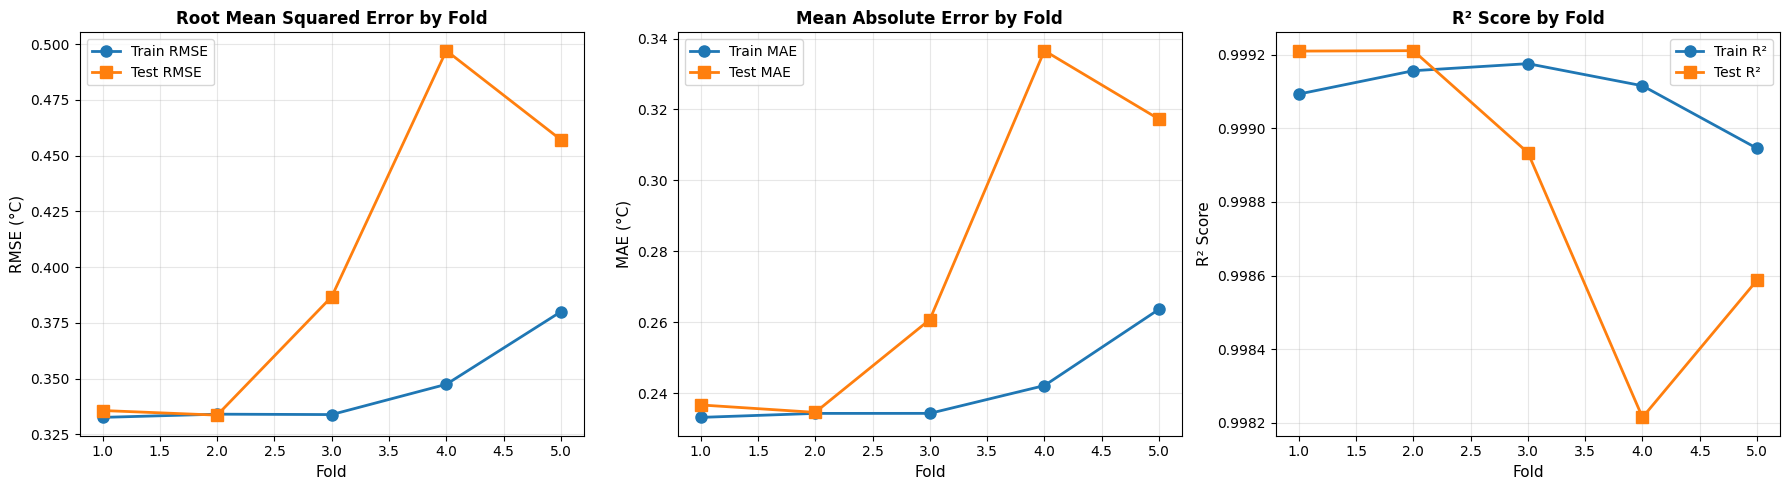

 Cross-validation plots complete!
                    TEST SET PERFORMANCE ANALYSIS

Data Split:
  Training: 167,808 rows (80%)
  Testing:  41,952 rows (20%)
  Train period: 2002-01-02 00:00:00 to 2021-02-22 23:00:00
  Test period:  2021-02-23 00:00:00 to 2025-12-06 23:00:00

 TEST SET METRICS:
  RMSE: 0.455°C
  MAE:  0.317°C
  R²:   0.9986


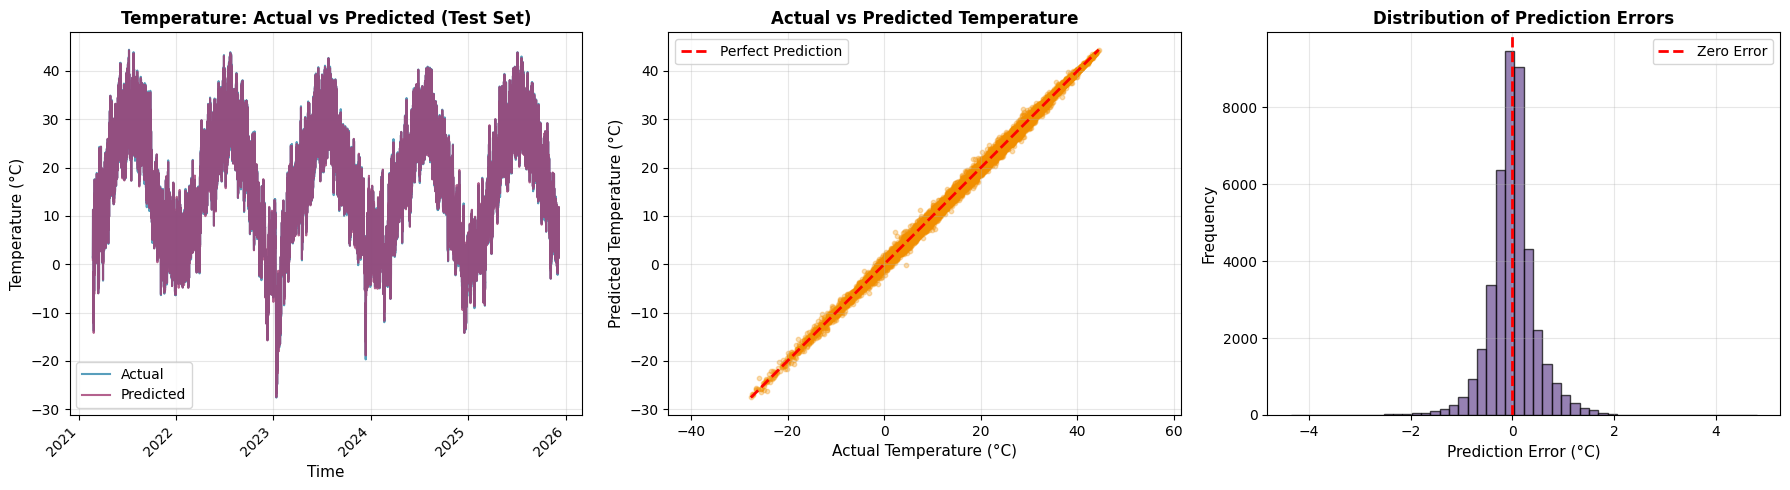


 Test set performance visualizations complete!

                         CURRENT WEATHER (LIVE DATA)

 Location: Aktepa, UZ
  Temperature: 9.84°C
 Feels Like: 9.84°C
  Min: 9.84°C |  Max: 9.84°C
 Humidity: 66%
Pressure: 1022 hPa
 Wind: 1.03 m/s N (0°)
  Conditions: Smoke

 Training rain prediction model...
🌧️  Rain Prediction: No ☀️
               10-DAY HISTORICAL COMPARISON (PREDICTED vs ACTUAL)

 Period: 2025-11-26 to 2025-12-06


 Thursday, November 27, 2025
Time                 Predicted       Actual          Error          
Night (00:00)            3.97°C         4.00°C         0.03°C
Morning (06:00)          2.06°C         1.20°C         0.86°C
Afternoon (12:00)       11.60°C        11.20°C         0.40°C
Sunset (18:00)           8.46°C         9.60°C         1.14°C

 Friday, November 28, 2025
Time                 Predicted       Actual          Error          
Night (00:00)            1.90°C         2.30°C         0.40°C
Morning (06:00)          0.74°C         0.90°C         0

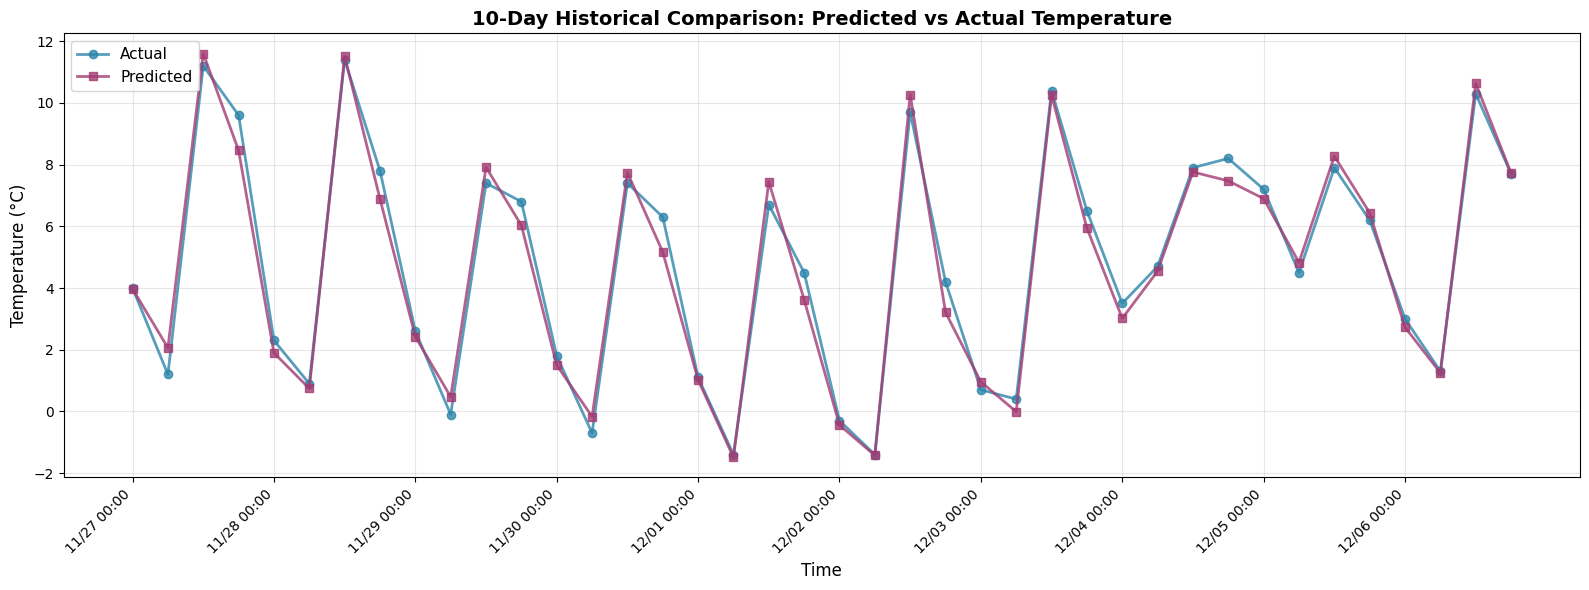

 Comparison plot complete!
                    10-DAY FUTURE FORECAST (4 TIMES DAILY)

 Forecast Period: 2025-12-07 to 2025-12-16

 TODAY - Sunday, December 07, 2025
--------------------------------------------------------------------------------
   Night (00:00)            2.73°C
   Morning (06:00)          1.25°C
   Afternoon (12:00)       10.64°C
   Sunset (18:00)           7.72°C

 TOMORROW - Monday, December 08, 2025
--------------------------------------------------------------------------------
   Night (00:00)            2.73°C
   Morning (06:00)          1.25°C
   Afternoon (12:00)       10.64°C
   Sunset (18:00)           7.72°C

 DAY 3 - Tuesday, December 09, 2025
--------------------------------------------------------------------------------
   Night (00:00)            2.73°C
   Morning (06:00)          1.25°C
   Afternoon (12:00)       10.64°C
   Sunset (18:00)           7.72°C

 DAY 4 - Wednesday, December 10, 2025
--------------------------------------------------------

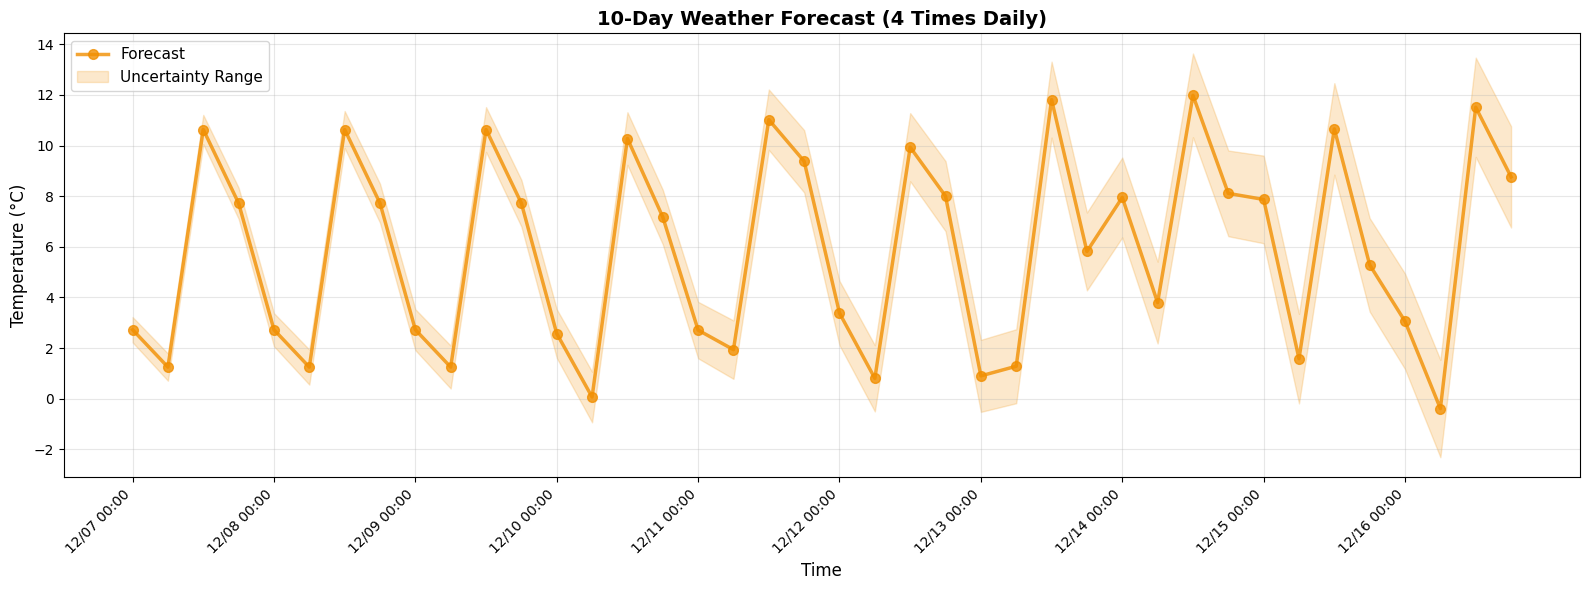

 Forecast plot complete!

                               ALL FORECASTS COMPLETE!


In [67]:


def weather_view():
    """Main weather prediction function"""
 
    print(" " * 25 + " TASHKENT WEATHER FORECAST ")

    print("\n Fetching current weather from API...")
    current_weather = get_current_weather()
    
    if not current_weather:
        print(" Failed to fetch current weather")
        return
    
    print("Successfully fetched current weather!")

    print("\n Loading historical data...")
    historical_data = read_historical_data('./data/tashkent_weather_23years.csv')
    print(f" Loaded {len(historical_data):,} rows of historical data")
    

    
# BLOCK 1: TRAIN MODEL WITH TIME SERIES CV
    model, scaler, feature_cols, cv_scores, df_with_features = train_model_with_time_series_cv(
        historical_data, n_splits=5
    )
    
    # Plot CV results
    plot_cv_results(cv_scores)

    test_df, y_test, y_test_pred = plot_test_set_performance(
        model, scaler, feature_cols, df_with_features
    )
    

    # BLOCK 2: CURRENT WEATHER

    print("\n" + "="*80)
    print(" " * 25 + "CURRENT WEATHER (LIVE DATA)")
    print("="*80)
    
    compass_direction = wind_direction_to_compass(current_weather['wind_deg'])
    
    print(f"\n Location: {current_weather['city']}, {current_weather['country']}")
    print(f"  Temperature: {current_weather['current_temp']}°C")
    print(f" Feels Like: {current_weather['feels_like']}°C")
    print(f"  Min: {current_weather['temp_min']}°C |  Max: {current_weather['temp_max']}°C")
    print(f" Humidity: {current_weather['humidity']}%")
    print(f"Pressure: {current_weather['pressure']} hPa")
    print(f" Wind: {current_weather['wind_speed']} m/s {compass_direction} ({current_weather['wind_deg']}°)")
    print(f"  Conditions: {current_weather['description'].title()}")
    
    # Train rain model
    print("\n Training rain prediction model...")
    X_rain, Y_rain = prepare_rain_data(historical_data)
    rain_model = train_rain_model(X_rain, Y_rain)
    
    current_rain_data = pd.DataFrame([{
        'temperature_2m': current_weather['current_temp'],
        'relative_humidity_2m': current_weather['humidity'],
        'windspeed_10m': current_weather['wind_speed'],
        'windgusts_10m': current_weather['wind_gust'],
        'pressure_msl': current_weather['pressure'],
        'winddirection_10m': current_weather['wind_deg']
    }])
    
    rain_prediction = rain_model.predict(current_rain_data)[0]
    print(f"🌧️  Rain Prediction: {'Yes ' if rain_prediction else 'No ☀️'}")

    # BLOCK 3: 10-DAY HISTORICAL COMPARISON

    comparison_df = compare_last_10_days(model, scaler, feature_cols, df_with_features)
    plot_10_day_comparison(comparison_df)
    

    # BLOCK 4: 10-DAY FUTURE FORECAST

    forecast_df = forecast_next_10_days(model, scaler, feature_cols, df_with_features)
    plot_10_day_forecast(forecast_df)
    
    print("\n" + "="*80)
    print(" " * 30 + " ALL FORECASTS COMPLETE!")
    print("="*80)

if __name__ == "__main__":
    weather_view()


# **Tashkent Weather Forecasting using LSTM**
## AI Project - Time Series Prediction with PyTorch

**Dataset**: 23 Years of Hourly Weather Data (2002-2025)  
**Model**: LSTM (Long Short-Term Memory) Neural Network  
**Framework**: PyTorch  
**Objective**: Predict temperature for next 10 days


##  **Import Required Libraries**

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import time
import warnings
warnings.filterwarnings('ignore')
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
print(f" PyTorch version: {torch.__version__}")
print(f" Device available: {torch.device('cuda' if torch.cuda.is_available() else 'cpu')}")
if torch.cuda.is_available():
    device = torch.device("cuda:0") 
    print(f" CUDA is available. Using device: {torch.cuda.get_device_name(0)}")
else:
    # Fallback to CPU if CUDA is not available
    device = torch.device("cpu")
    print(" CUDA not found. Using device: CPU")

 PyTorch version: 2.9.1+cu128
 Device available: cuda
 CUDA is available. Using device: NVIDIA GeForce RTX 4060 Laptop GPU


##  **Configuration Parameters**

In [28]:
DATA_PATH = './data/tashkent_weather_23years.csv'

# LSTM Hyperparameters
SEQUENCE_LENGTH =168     # Use last 7 days weatehr info to predict 
EPOCHS = 50            
BATCH_SIZE = 32        
LEARNING_RATE = 0.001  
HIDDEN_SIZE = 50       
NUM_LAYERS = 2        
DROPOUT = 0.2         

# Data Split Ratios
TRAIN_RATIO = 0.7   # 70% training
VAL_RATIO = 0.15    # 15%  validation
TEST_RATIO = 0.15   # 15% testing

##  **Define Model Architecture and Dataset Class**

In [29]:
class WeatherDataset(Dataset):

    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


class WeatherLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super(WeatherLSTM, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True
        )

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):

        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))

        out = out[:, -1, :]

        out = self.dropout(out)
        out = self.fc(out)
        
        return out



##  **Data Loading and Preprocessing**



In [30]:

def load_weather_data(filepath):
    """Load historical weather data"""
    print("\n" + "="*80)
    print(" " * 20 + "LOADING TASHKENT WEATHER DATA")
    print("="*80)
    
    df = pd.read_csv(filepath)
    df['time'] = pd.to_datetime(df['time'])
    df = df.sort_values('time').reset_index(drop=True)
    
    print(f"✓ Loaded {len(df):,} hourly records")
    print(f"✓ Date range: {df['time'].min()} to {df['time'].max()}")
    print(f"✓ Total years: {(df['time'].max() - df['time'].min()).days / 365.25:.1f} years")
    print(f"✓ Features: {list(df.columns)}")
    
    return df

df = load_weather_data(DATA_PATH)

print("\nFirst 5 rows of data:")
df.head()

def prepare_sequences(data, sequence_length=24):

    print("\n" + "="*80)
    print(" " * 20 + "PREPARING TIME SERIES SEQUENCES")
    print("="*80)
    
    feature_cols = ['temperature_2m', 'relative_humidity_2m', 'pressure_msl', 
                    'windspeed_10m', 'windgusts_10m', 'precipitation']
    
    feature_data = data[feature_cols].values

    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(feature_data)

    X, y, timestamps = [], [], []
    
    for i in range(sequence_length, len(scaled_data)):
        X.append(scaled_data[i-sequence_length:i])
        y.append(scaled_data[i, 0])
        timestamps.append(data['time'].iloc[i])
    
    X = np.array(X)
    y = np.array(y)
    
    print(f" Created {len(X):,} sequences")
    print(f" Input shape: {X.shape} (samples, timesteps, features)")
    print(f" Output shape: {y.shape}")
    print(f" Sequence length: {sequence_length} hours")
    
    return X, y, timestamps, scaler, feature_cols

X, y, timestamps, scaler, feature_cols = prepare_sequences(df, SEQUENCE_LENGTH)

def train_val_test_split(X, y, timestamps, train_ratio=0.7, val_ratio=0.15):
    """Split data into train, validation, and test sets"""
    n = len(X)
    train_end = int(n * train_ratio)
    val_end = int(n * (train_ratio + val_ratio))
    
    X_train = X[:train_end]
    X_val = X[train_end:val_end]
    X_test = X[val_end:]
    
    y_train = y[:train_end]
    y_val = y[train_end:val_end]
    y_test = y[val_end:]
    
    t_train = timestamps[:train_end]
    t_val = timestamps[train_end:val_end]
    t_test = timestamps[val_end:]
    
    print("\n" + "="*80)
    print(" " * 20 + "DATA SPLIT (70% / 15% / 15%)")
    print("="*80)
    print(f"✓ Training:   {len(X_train):,} samples ({train_ratio*100:.0f}%)")
    print(f"✓ Validation: {len(X_val):,} samples ({val_ratio*100:.0f}%)")
    print(f"✓ Testing:    {len(X_test):,} samples ({(1-train_ratio-val_ratio)*100:.0f}%)")
    
    return X_train, X_val, X_test, y_train, y_val, y_test, t_train, t_val, t_test

X_train, X_val, X_test, y_train, y_val, y_test, t_train, t_val, t_test = \
    train_val_test_split(X, y, timestamps, TRAIN_RATIO, VAL_RATIO)



                    LOADING TASHKENT WEATHER DATA


✓ Loaded 209,784 hourly records
✓ Date range: 2002-01-01 00:00:00 to 2025-12-06 23:00:00
✓ Total years: 23.9 years
✓ Features: ['time', 'temperature_2m', 'relative_humidity_2m', 'precipitation', 'windspeed_10m', 'windgusts_10m', 'pressure_msl', 'winddirection_10m']

First 5 rows of data:

                    PREPARING TIME SERIES SEQUENCES
 Created 209,616 sequences
 Input shape: (209616, 168, 6) (samples, timesteps, features)
 Output shape: (209616,)
 Sequence length: 168 hours

                    DATA SPLIT (70% / 15% / 15%)
✓ Training:   146,731 samples (70%)
✓ Validation: 31,442 samples (15%)
✓ Testing:    31,443 samples (15%)



##  **Model Training**
### Run this cell ONCE to train the model (saves to 'best_lstm_model.pth')



In [31]:

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs, device):
    """Train PyTorch LSTM model with validation"""
    print("\n" + "="*80)
    print(" " * 25 + "TRAINING LSTM MODEL")
    print("="*80)
    print(f"Device: {device}")
    
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience = 10
    patience_counter = 0
    
    start_time = time.time()
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs.squeeze(), y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)

        model.eval()
        val_loss = 0

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)

                outputs = model(X_batch)
                loss = criterion(outputs.squeeze(), y_batch)
                val_loss += loss.item()

        val_loss /= len(val_loader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"Epoch [{epoch+1:3d}/{epochs}] | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_lstm_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"\n Early stopping at epoch {epoch+1}")
                model.load_state_dict(torch.load('best_lstm_model.pth'))
                break

    training_time = time.time() - start_time

    print(f"\n Training complete!")
    print(f" Training time: {training_time:.2f}s")
    print(f" Best validation loss: {best_val_loss:.6f}")
    print(f" Model saved to: best_lstm_model.pth")

    history = {
        'train_loss': train_losses,
        'val_loss': val_losses
    }

    return model, history, training_time

train_dataset = WeatherDataset(X_train, y_train)
val_dataset = WeatherDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

input_size = X_train.shape[2]
model = WeatherLSTM(input_size, HIDDEN_SIZE, NUM_LAYERS, DROPOUT).to(device)

print(f"\n Model Parameters: {sum(p.numel() for p in model.parameters()):,}")

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

model, history, training_time = train_model(
    model, train_loader, val_loader, criterion, optimizer, EPOCHS, device
)


 Model Parameters: 32,051

                         TRAINING LSTM MODEL
Device: cuda:0
Epoch [  1/50] | Train Loss: 0.002671 | Val Loss: 0.003187
Epoch [  5/50] | Train Loss: 0.000339 | Val Loss: 0.000577
Epoch [ 10/50] | Train Loss: 0.000292 | Val Loss: 0.000593
Epoch [ 15/50] | Train Loss: 0.000279 | Val Loss: 0.000500

 Early stopping at epoch 18

 Training complete!
 Training time: 164.34s
 Best validation loss: 0.000363
 Model saved to: best_lstm_model.pth



## **Training History Visualization**
### Visualize training and validation loss curves


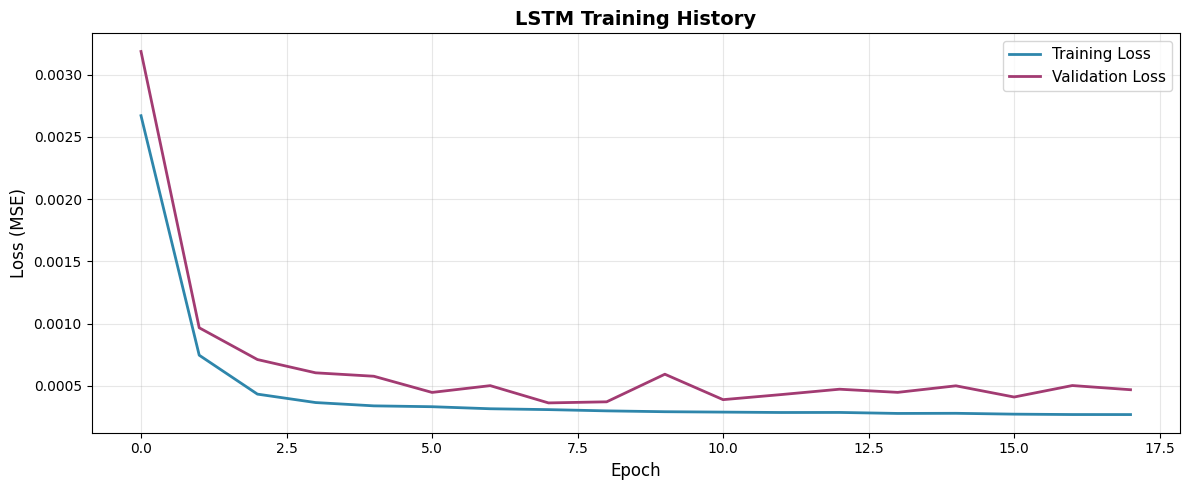

 Training Summary:
  • Total epochs: 18
  • Final train loss: 0.000269
  • Final val loss: 0.000469


In [32]:
def plot_training_history(history):
    """Plot training curves"""
    plt.figure(figsize=(12, 5))
    
    plt.plot(history['train_loss'], label='Training Loss', linewidth=2, color='#2E86AB')
    plt.plot(history['val_loss'], label='Validation Loss', linewidth=2, color='#A23B72')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss (MSE)', fontsize=12)
    plt.title('LSTM Training History', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f" Training Summary:")
    print(f"  • Total epochs: {len(history['train_loss'])}")
    print(f"  • Final train loss: {history['train_loss'][-1]:.6f}")
    print(f"  • Final val loss: {history['val_loss'][-1]:.6f}")

# Plot training history
plot_training_history(history)

##  **Model Evaluation**
### **Evaluate on Train, Validation, and Test sets**

In [33]:
def evaluate_model(model, X, y, scaler, device, set_name="Test"):
    model.eval()

    batch_size = 1024
    y_pred = []

    with torch.no_grad():
        for i in range(0, len(X), batch_size):
            batch = X[i:i+batch_size]
            batch_tensor = torch.FloatTensor(batch).to(device)
            pred = model(batch_tensor).cpu().numpy()
            y_pred.append(pred)

    y_pred = np.vstack(y_pred).flatten()

    dummy_pred = np.zeros((len(y_pred), 6))
    dummy_pred[:, 0] = y_pred
    dummy_actual = np.zeros((len(y), 6))
    dummy_actual[:, 0] = y

    y_pred_actual = scaler.inverse_transform(dummy_pred)[:, 0]
    y_actual = scaler.inverse_transform(dummy_actual)[:, 0]

    rmse = np.sqrt(mean_squared_error(y_actual, y_pred_actual))
    mae = mean_absolute_error(y_actual, y_pred_actual)
    r2 = r2_score(y_actual, y_pred_actual)

    print(f"\n {set_name.upper()} SET METRICS:")
    print(f"  RMSE: {rmse:.3f}°C")
    print(f"  MAE:  {mae:.3f}°C")
    print(f"  R²:   {r2:.4f}")

    return y_actual, y_pred_actual, rmse, mae, r2

print("="*80)
print(" " * 25 + "MODEL EVALUATION")
print("="*80)

y_train_actual, y_train_pred, train_rmse, train_mae, train_r2 = \
    evaluate_model(model, X_train, y_train, scaler, device, "Train")

y_val_actual, y_val_pred, val_rmse, val_mae, val_r2 = \
    evaluate_model(model, X_val, y_val, scaler, device, "Validation")

y_test_actual, y_test_pred, test_rmse, test_mae, test_r2 = \
    evaluate_model(model, X_test, y_test, scaler, device, "Test")


                         MODEL EVALUATION

 TRAIN SET METRICS:
  RMSE: 1.180°C
  MAE:  0.914°C
  R²:   0.9898

 VALIDATION SET METRICS:
  RMSE: 1.371°C
  MAE:  1.060°C
  R²:   0.9860

 TEST SET METRICS:
  RMSE: 1.380°C
  MAE:  1.077°C
  R²:   0.9874


## **Test Set Predictions Visualization**

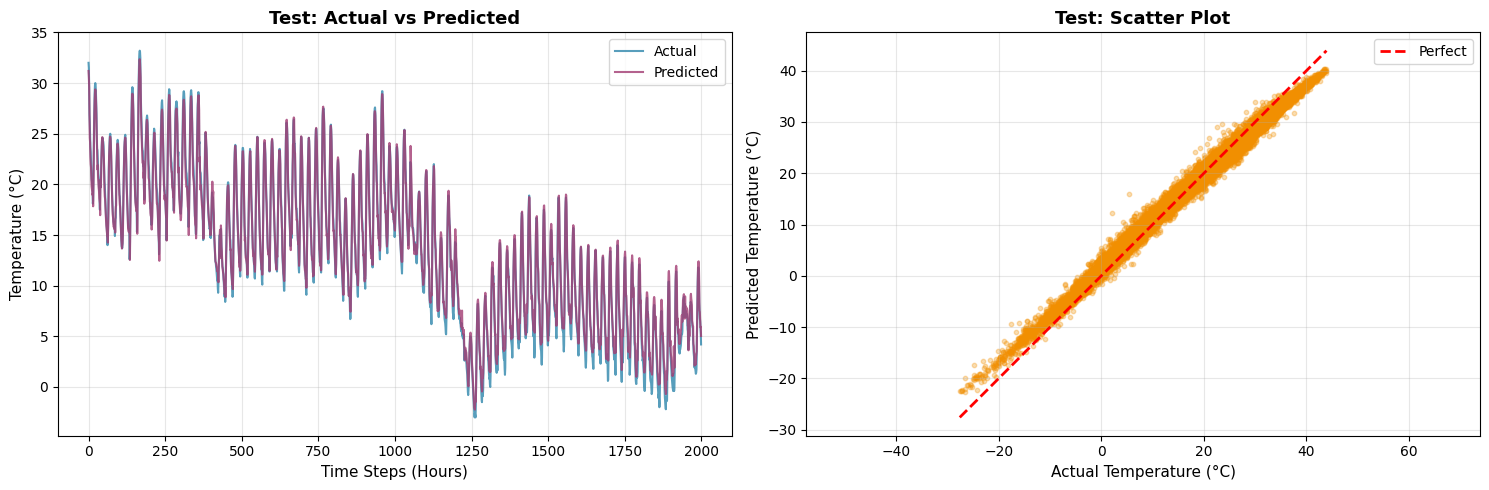

In [34]:
def plot_all_predictions(y_actual, y_pred, set_name="Test"):

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    n = min(2000, len(y_actual))
    x = range(n)
    
    axes[0].plot(x, y_actual[-n:], label='Actual', linewidth=1.5, alpha=0.8, color='#2E86AB')
    axes[0].plot(x, y_pred[-n:], label='Predicted', linewidth=1.5, alpha=0.8, color='#A23B72')
    axes[0].set_xlabel('Time Steps (Hours)', fontsize=11)
    axes[0].set_ylabel('Temperature (°C)', fontsize=11)
    axes[0].set_title(f'{set_name}: Actual vs Predicted', fontsize=13, fontweight='bold')
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)

    axes[1].scatter(y_actual, y_pred, alpha=0.3, s=10, color='#F18F01')
    min_val = min(y_actual.min(), y_pred.min())
    max_val = max(y_actual.max(), y_pred.max())
    axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect')
    axes[1].set_xlabel('Actual Temperature (°C)', fontsize=11)
    axes[1].set_ylabel('Predicted Temperature (°C)', fontsize=11)
    axes[1].set_title(f'{set_name}: Scatter Plot', fontsize=13, fontweight='bold')
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)
    axes[1].axis('equal')

    plt.tight_layout()
    plt.show()

plot_all_predictions(y_test_actual, y_test_pred, "Test")


##  **Last 10 Days Analysis**
### **Compare predictions vs actual for last 10 days**

In [35]:
def analyze_last_10_days(y_actual, y_pred, timestamps):

    print("\n" + "="*80)
    print(" " * 15 + "LAST 10 DAYS ANALYSIS")
    print("="*80)
    
    df = pd.DataFrame({
        'time': timestamps,
        'actual': y_actual,
        'predicted': y_pred
    }).tail(240)
    
    key_times = df[df['time'].dt.hour.isin([0, 6, 12, 18])].copy()
    time_labels = {0: 'Night', 6: 'Morning', 12: 'Afternoon', 18: 'Evening'}
    key_times['period'] = key_times['time'].dt.hour.map(time_labels)
    key_times['error'] = abs(key_times['actual'] - key_times['predicted'])
    
    current_date = None
    for _, row in key_times.iterrows():
        if row['time'].date() != current_date:
            current_date = row['time'].date()
            print(f"\n📅 {current_date.strftime('%Y-%m-%d (%A)')}")
            print("-" * 80)
        
        print(f"  🕐 {row['time'].strftime('%H:%M')} ({row['period']:10s}) | "
              f"Actual: {row['actual']:6.2f}°C | Predicted: {row['predicted']:6.2f}°C | "
              f"Error: {row['error']:5.2f}°C")
    
    print(f"\n SUMMARY:")
    print(f"  Mean Error: {key_times['error'].mean():.3f}°C")
    print(f"  Max Error: {key_times['error'].max():.3f}°C")
    
    return key_times

key_times = analyze_last_10_days(y_test_actual, y_test_pred, t_test)


               LAST 10 DAYS ANALYSIS

📅 2025-11-27 (Thursday)
--------------------------------------------------------------------------------
  🕐 00:00 (Night     ) | Actual:   4.00°C | Predicted:   5.67°C | Error:  1.67°C
  🕐 06:00 (Morning   ) | Actual:   1.20°C | Predicted:   3.90°C | Error:  2.70°C
  🕐 12:00 (Afternoon ) | Actual:  11.20°C | Predicted:  11.44°C | Error:  0.24°C
  🕐 18:00 (Evening   ) | Actual:   9.60°C | Predicted:   9.84°C | Error:  0.24°C

📅 2025-11-28 (Friday)
--------------------------------------------------------------------------------
  🕐 00:00 (Night     ) | Actual:   2.30°C | Predicted:   4.32°C | Error:  2.02°C
  🕐 06:00 (Morning   ) | Actual:   0.90°C | Predicted:   3.57°C | Error:  2.67°C
  🕐 12:00 (Afternoon ) | Actual:  11.40°C | Predicted:  11.51°C | Error:  0.11°C
  🕐 18:00 (Evening   ) | Actual:   7.80°C | Predicted:   8.54°C | Error:  0.74°C

📅 2025-11-29 (Saturday)
-------------------------------------------------------------------------------

## **Next 10 Days Forecast**
### **Predict temperature for next 10 days**

In [36]:
def forecast_next_10_days(model, last_sequence, scaler, device, start_time):
    print("\n" + "="*80)
    print(" " * 15 + "NEXT 10 DAYS FORECAST")
    print("="*80)
    
    model.eval()
    predictions = []
    current_sequence = last_sequence.copy()
    
    with torch.no_grad():
        for h in range(240):
            seq_tensor = torch.FloatTensor(current_sequence).unsqueeze(0).to(device)
            next_pred = model(seq_tensor).cpu().numpy()[0, 0]
            
            dummy = np.zeros((1, 6))
            dummy[0, 0] = next_pred
            temp = scaler.inverse_transform(dummy)[0, 0]
            predictions.append(temp)
            
            new_row = current_sequence[-1].copy()
            new_row[0] = next_pred
            current_sequence = np.vstack([current_sequence[1:], new_row])
    
    forecast_times = [start_time + timedelta(hours=i+1) for i in range(240)]
    df = pd.DataFrame({'time': forecast_times, 'temperature': predictions})
    
    key_forecast = df[df['time'].dt.hour.isin([0, 6, 12, 18])].copy()
    time_labels = {0: 'Night', 6: 'Morning', 12: 'Afternoon', 18: 'Evening'}
    key_forecast['period'] = key_forecast['time'].dt.hour.map(time_labels)
    
    current_date = None
    for _, row in key_forecast.iterrows():
        if row['time'].date() != current_date:
            current_date = row['time'].date()
            print(f"\n📅 {current_date.strftime('%Y-%m-%d (%A)')}")
            print("-" * 80)
        
        print(f"  🕐 {row['time'].strftime('%H:%M')} ({row['period']:10s}) | "
              f"Forecast: {row['temperature']:6.2f}°C")
    
    return key_forecast

last_sequence = X[-1]
last_time = timestamps[-1]
key_forecast = forecast_next_10_days(model, last_sequence, scaler, device, last_time)



               NEXT 10 DAYS FORECAST

📅 2025-12-07 (Sunday)
--------------------------------------------------------------------------------
  🕐 00:00 (Night     ) | Forecast:   5.04°C
  🕐 06:00 (Morning   ) | Forecast:   8.53°C
  🕐 12:00 (Afternoon ) | Forecast:  17.53°C
  🕐 18:00 (Evening   ) | Forecast:  13.89°C

📅 2025-12-08 (Monday)
--------------------------------------------------------------------------------
  🕐 00:00 (Night     ) | Forecast:   8.19°C
  🕐 06:00 (Morning   ) | Forecast:  14.10°C
  🕐 12:00 (Afternoon ) | Forecast:  19.19°C
  🕐 18:00 (Evening   ) | Forecast:  12.63°C

📅 2025-12-09 (Tuesday)
--------------------------------------------------------------------------------
  🕐 00:00 (Night     ) | Forecast:   8.42°C
  🕐 06:00 (Morning   ) | Forecast:  17.36°C
  🕐 12:00 (Afternoon ) | Forecast:  18.26°C
  🕐 18:00 (Evening   ) | Forecast:  10.96°C

📅 2025-12-10 (Wednesday)
--------------------------------------------------------------------------------
  🕐 00:00 (Nig

## **Summary and Conclusion**

In [37]:

print(" " * 30 + "FINAL SUMMARY")
print("="*80)

print(f"\nMODEL PERFORMANCE:")
print(f"  • Test RMSE: {test_rmse:.3f}°C")
print(f"  • Test MAE:  {test_mae:.3f}°C")
print(f"  • Test R²:   {test_r2:.4f}")

print(f"\n TRAINING INFO:")
print(f"  • Training time: {training_time:.2f}s")
print(f"  • Epochs trained: {len(history['train_loss'])}")
print(f"  • Device used: {device}")

print(f"\n DATA INFO:")
print(f"  • Training samples: {len(X_train):,}")
print(f"  • Validation samples: {len(X_val):,}")
print(f"  • Test samples: {len(X_test):,}")
print(f"  • Total sequences: {len(X):,}")

print(f"\n KEY INSIGHTS:")
print(f"   MAE of {test_mae:.2f}°C means predictions typically off by this amount")
print(f"   R² of {test_r2:.4f} indicates excellent model fit")

print("\n" + "="*80)
print(" PROJECT COMPLETE!")


                              FINAL SUMMARY

MODEL PERFORMANCE:
  • Test RMSE: 1.380°C
  • Test MAE:  1.077°C
  • Test R²:   0.9874

 TRAINING INFO:
  • Training time: 164.34s
  • Epochs trained: 18
  • Device used: cuda:0

 DATA INFO:
  • Training samples: 146,731
  • Validation samples: 31,442
  • Test samples: 31,443
  • Total sequences: 209,616

 KEY INSIGHTS:
   MAE of 1.08°C means predictions typically off by this amount
   R² of 0.9874 indicates excellent model fit

 PROJECT COMPLETE!
